# Context-aware Retrieval Benchmarks

This notebook measures how well each representation rung supports context retrieval for a prompt/task. We load companion traces, encode the current session at each rung, and see whether the correct file/snippet (the latest target file in the trace) appears among the top-k retrievals.

## Representation Rungs

- **tokens** (Rung 1): Raw token-level representation with PII redaction - captures exact text changes but lowest privacy
- **semantic_edits** (Rung 2): AST-based edit operations (e.g., "ADD_FUNCTION->file.ts") - captures intent without raw code
- **functions** (Rung 3): Function signatures and module-level changes - abstracts away implementation details
- **files** (Rung 4): File-level collaboration graph with action counts - represents files as nodes with edit/navigation/context interaction counts
- **dependencies** (Rung 5): Dependency graph - file/module import relationships - captures structural dependencies between files without revealing content or frequency
- **motifs** (Rung 6): Workflow patterns and high-level sequences - highest abstraction, workflow-level patterns only

We report MRR/recall@k, average representation size, action counts per file, and visualizations comparing retrieval quality across the ladder. Use `export_traces_from_db()` when you need fresh data.


In [17]:
# Imports and function definitions are in the next cell



In [18]:
from __future__ import annotations

import json
import os
import sqlite3
from collections import OrderedDict
from pathlib import Path
from typing import Callable, Dict, List, Sequence

import ast
import math
import re
import zlib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def _find_repo_root() -> Path:
    current = Path.cwd().resolve()
    while True:
        if (current / "cursor-telemetry").exists():
            return current
        if current == current.parent:
            raise FileNotFoundError("Cannot locate cursor-telemetry repo root")
        current = current.parent


REPO_ROOT = _find_repo_root()
EXPORT_FILE = REPO_ROOT / "research/data/companion_traces.jsonl"
COMPANION_DB = REPO_ROOT / "cursor-telemetry/components/activity-logger/companion/data/companion.db"
EXPORT_FILE.parent.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = REPO_ROOT / "research/results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SELECTED_RUNGS = ["tokens", "semantic_edits", "functions", "files", "dependencies", "motifs"]
EXPORT_SCRIPT = REPO_ROOT / "cursor-telemetry/components/activity-logger/companion/scripts/export_cursor_data.sh"


def load_traces_from_db(limit: int | None = None) -> List[Dict]:
    """
    Load traces directly from the companion SQLite database.
    Includes events, prompts, and terminal commands.
    If limit is specified, returns the most recent N sessions.
    """
    if not COMPANION_DB.exists():
        return []

    sessions: Dict[str, Dict] = {}
    prompts_by_session: Dict[str, List[Dict]] = {}
    terminal_by_session: Dict[str, List[Dict]] = {}
    
    with sqlite3.connect(COMPANION_DB) as conn:
        conn.row_factory = sqlite3.Row
        
        # Get all events ordered by timestamp
        query = (
            "SELECT id, session_id, workspace_path, type, timestamp, details, annotation, intent, tags, ai_generated "
            "FROM events ORDER BY timestamp"
        )
        cursor = conn.execute(query)
        for row in cursor:
            sid = row["session_id"] or f"session_{row['id']}"
            session = sessions.setdefault(
                sid,
                {
                    "session_id": sid,
                    "workspace_path": row["workspace_path"] or "unknown",
                    "events": [],
                },
            )
            details_raw = row["details"]
            if details_raw:
                try:
                    details_payload = json.loads(details_raw)
                except json.JSONDecodeError:
                    details_payload = details_raw
            else:
                details_payload = None
            session["events"].append(
                {
                    "id": row["id"],
                    "type": row["type"],
                    "timestamp": row["timestamp"],
                    "details": details_payload,
                    "annotation": row["annotation"],
                    "intent": row["intent"],
                    "tags": row["tags"],
                    "ai_generated": bool(row["ai_generated"]),
                }
            )
        
        # Get prompts with context files
        try:
            # Check if session_id column exists in prompts table
            cursor = conn.execute("PRAGMA table_info(prompts)")
            columns = [col[1] for col in cursor.fetchall()]
            has_session_id = "session_id" in columns
            
            if has_session_id:
                prompts_query = """
                    SELECT id, timestamp, text, workspace_path, context_files_json, 
                           context_file_count, session_id, conversation_id
                    FROM prompts
                    WHERE text IS NOT NULL AND text != '' AND text != 'NA'
                    ORDER BY timestamp
                """
            else:
                prompts_query = """
                    SELECT id, timestamp, text, workspace_path, context_files_json, 
                           context_file_count, conversation_id
                    FROM prompts
                    WHERE text IS NOT NULL AND text != '' AND text != 'NA'
                    ORDER BY timestamp
                """
            
            for row in conn.execute(prompts_query):
                row_dict = dict(row)
                # Use session_id if available, otherwise use workspace_path to group
                if has_session_id:
                    sid = row_dict.get("session_id") or row_dict.get("workspace_path") or f"prompt_{row_dict['id']}"
                else:
                    sid = row_dict.get("workspace_path") or f"prompt_{row_dict['id']}"
                
                if sid not in prompts_by_session:
                    prompts_by_session[sid] = []
                
                context_files = []
                if row_dict.get("context_files_json"):
                    try:
                        context_files_raw = json.loads(row_dict["context_files_json"])
                        # Handle different structures: array of strings or array of objects
                        if isinstance(context_files_raw, list):
                            context_files = context_files_raw
                        elif isinstance(context_files_raw, dict) and "files" in context_files_raw:
                            context_files = context_files_raw["files"]
                    except (json.JSONDecodeError, TypeError):
                        pass
                
                prompts_by_session[sid].append({
                    "id": row_dict["id"],
                    "type": "prompt",
                    "timestamp": row_dict["timestamp"],
                    "details": {
                        "text": row_dict.get("text", ""),
                        "context_files": context_files,
                        "context_file_count": row_dict.get("context_file_count") or 0,
                        "conversation_id": row_dict.get("conversation_id"),
                    },
                    "workspace_path": row_dict.get("workspace_path"),
                })
        except sqlite3.OperationalError as e:
            # Prompts table might not exist
            print(f"Note: Could not load prompts: {e}")
            pass
        
        # Get terminal commands
        try:
            # Check if session_id column exists in terminal_commands table
            cursor = conn.execute("PRAGMA table_info(terminal_commands)")
            columns = [col[1] for col in cursor.fetchall()]
            has_session_id = "session_id" in columns
            
            if has_session_id:
                terminal_query = """
                    SELECT id, timestamp, command, workspace, session_id, linked_entry_id, linked_prompt_id
                    FROM terminal_commands
                    ORDER BY timestamp
                """
            else:
                terminal_query = """
                    SELECT id, timestamp, command, workspace, linked_entry_id, linked_prompt_id
                    FROM terminal_commands
                    ORDER BY timestamp
                """
            
            for row in conn.execute(terminal_query):
                row_dict = dict(row)
                # Use session_id if available, otherwise use workspace to group
                if has_session_id:
                    sid = row_dict.get("session_id") or row_dict.get("workspace") or f"terminal_{row_dict['id']}"
                else:
                    sid = row_dict.get("workspace") or f"terminal_{row_dict['id']}"
                
                if sid not in terminal_by_session:
                    terminal_by_session[sid] = []
                
                terminal_by_session[sid].append({
                    "id": row_dict["id"],
                    "type": "terminal_command",
                    "timestamp": row_dict["timestamp"],
                    "details": {
                        "command": row_dict.get("command", ""),
                        "workspace": row_dict.get("workspace"),
                        "linked_entry_id": row_dict.get("linked_entry_id"),
                        "linked_prompt_id": row_dict.get("linked_prompt_id"),
                    },
                    "workspace_path": row_dict.get("workspace"),
                })
        except sqlite3.OperationalError as e:
            # Terminal commands table might not exist
            print(f"Note: Could not load terminal commands: {e}")
            pass
    
    # Merge prompts and terminal commands into sessions
    for sid, prompts in prompts_by_session.items():
        if sid in sessions:
            sessions[sid]["events"].extend(prompts)
        else:
            sessions[sid] = {
                "session_id": sid,
                "workspace_path": prompts[0]["workspace_path"] if prompts else "unknown",
                "events": prompts,
            }
    
    for sid, terminals in terminal_by_session.items():
        if sid in sessions:
            sessions[sid]["events"].extend(terminals)
        else:
            sessions[sid] = {
                "session_id": sid,
                "workspace_path": terminals[0]["workspace_path"] if terminals else "unknown",
                "events": terminals,
            }
    
    # Sort events by timestamp within each session
    for session in sessions.values():
        session["events"].sort(key=lambda e: e.get("timestamp", ""))
    
    # Convert to list and apply limit if specified (most recent sessions)
    session_list = list(sessions.values())
    if limit is not None and limit > 0:
        # Sort by most recent event timestamp and take last N
        session_list.sort(
            key=lambda s: max((str(e.get("timestamp", "")) for e in s.get("events", [])), default="")
        )
        session_list = session_list[-limit:]
    
    return session_list


def export_traces_from_db(output_path: Path = EXPORT_FILE, limit_sessions: int | None = None) -> Path:
    if not COMPANION_DB.exists():
        raise FileNotFoundError(f"Companion DB not found at {COMPANION_DB}")
    sessions: OrderedDict[str, Dict] = OrderedDict()
    query = (
        "SELECT id, session_id, workspace_path, type, timestamp, details, annotation, intent, tags, ai_generated "
        "FROM events ORDER BY timestamp"
    )
    with sqlite3.connect(COMPANION_DB) as conn:
        conn.row_factory = sqlite3.Row
        cursor = conn.execute(query)
        for row in cursor:
            sid = row["session_id"] or f"session_{row['id']}"
            session = sessions.setdefault(
                sid,
                {
                    "session_id": sid,
                    "workspace_path": row["workspace_path"] or "unknown",
                    "events": [],
                },
            )
            details_raw = row["details"]
            if details_raw:
                try:
                    details_payload = json.loads(details_raw)
                except json.JSONDecodeError:
                    details_payload = details_raw
            else:
                details_payload = None
            session["events"].append(
                {
                    "id": row["id"],
                    "type": row["type"],
                    "timestamp": row["timestamp"],
                    "details": details_payload,
                    "annotation": row["annotation"],
                    "intent": row["intent"],
                    "tags": row["tags"],
                    "ai_generated": bool(row["ai_generated"]),
                }
            )
    entries = list(sessions.values())
    if limit_sessions is not None:
        entries = entries[-limit_sessions:]
    with output_path.open("w", encoding="utf-8") as fh:
        for entry in entries:
            json.dump(entry, fh)
            fh.write("\n")
    return output_path


EXPORT_SCRIPT_EXISTS = EXPORT_SCRIPT.exists()


def load_exported_traces(limit: int | None = None):
    if not EXPORT_FILE.exists():
        return []
    traces = []
    with EXPORT_FILE.open("r", encoding="utf-8") as fh:
        for idx, line in enumerate(fh):
            if limit is not None and idx >= limit:
                break
            try:
                traces.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return traces


def token_rung(trace: Dict) -> str:
    tokens: List[str] = []
    for event in trace.get("events", []):
        token = event.get("token") or event.get("value") or event.get("text")
        if token:
            tokens.append(str(token))
        else:
            kind = event.get("type") or event.get("annotation")
            if kind:
                tokens.append(str(kind))
    return " ".join(tokens) or trace.get("session_id", "empty")


def semantic_edit_rung(trace: Dict) -> str:
    edits: List[str] = []
    for event in trace.get("events", []):
        details = event.get("details") or {}
        op = details.get("operation") or details.get("verb") or event.get("type")
        target = details.get("file_path") or details.get("file") or details.get("target")
        if op and target:
            edits.append(f"{op}->{target}")
        elif op:
            edits.append(str(op))
    if not edits:
        return token_rung(trace)[:512]
    return " | ".join(edits)


def function_rung(trace: Dict) -> str:
    functions: List[str] = []
    for event in trace.get("events", []):
        details = event.get("details") or {}
        module = details.get("module") or details.get("file_path") or event.get("workspace_path")
        func = details.get("function") or event.get("annotation")
        if module and func:
            functions.append(f"{module}.{func}")
        elif module:
            functions.append(str(module))
    return " -> ".join(functions) or trace.get("workspace_path", "unknown")


def count_ops(code: str) -> int:
    try:
        tree = ast.parse(code)
    except SyntaxError:
        return 0
    return sum(
        isinstance(node, (ast.If, ast.For, ast.While, ast.FunctionDef, ast.AsyncFunctionDef, ast.Assign))
        for node in ast.walk(tree)
    )


def extract_imports_from_code(file_path: str, code: str) -> List[str]:
    """
    Extract import statements from code using regex patterns.
    Returns list of imported module paths.
    """
    if not code:
        return []
    
    imports = []
    
    # Detect language from file extension
    file_ext = file_path.split('.')[-1].lower() if '.' in file_path else ''
    
    # Patterns for different languages
    patterns = {
        'js': [
            r"import\s+.*?\s+from\s+['\"](.+?)['\"]",
            r"require\(['\"](.+?)['\"]\)",
            r"import\(['\"](.+?)['\"]\)",
        ],
        'ts': [
            r"import\s+.*?\s+from\s+['\"](.+?)['\"]",
            r"import\s+['\"](.+?)['\"]",
        ],
        'tsx': [
            r"import\s+.*?\s+from\s+['\"](.+?)['\"]",
            r"import\s+['\"](.+?)['\"]",
        ],
        'jsx': [
            r"import\s+.*?\s+from\s+['\"](.+?)['\"]",
            r"require\(['\"](.+?)['\"]\)",
        ],
        'py': [
            r"^import\s+(\S+)",
            r"^from\s+(\S+)\s+import",
        ],
    }
    
    # Get patterns for this file type
    lang_patterns = patterns.get(file_ext, patterns.get('js', []))
    
    for pattern in lang_patterns:
        matches = re.findall(pattern, code, re.MULTILINE)
        imports.extend(matches)
    
    # Remove duplicates and filter out node_modules/external packages
    unique_imports = []
    seen = set()
    for imp in imports:
        # Skip node_modules and external packages (start with @ or don't start with .)
        if imp.startswith('.') or imp.startswith('/') or '/' in imp:
            # Relative or absolute path - keep it
            if imp not in seen:
                seen.add(imp)
                unique_imports.append(imp)
        # Skip external packages like 'react', 'lodash', etc.
    
    return unique_imports


def dependencies_rung(trace: Dict) -> str:
    """
    Rung 5: Dependency graph - file/module import relationships.
    More abstract than files (structure vs actions), less abstract than motifs.
    Captures static code structure (import statements) without revealing content or frequency.
    """
    dependencies = []
    seen_deps = set()
    
    for event in trace.get("events", []):
        details = event.get("details") or {}
        event_type = event.get("type", "").lower()
        
        # Only process code changes
        if event_type not in ("file_change", "code_change", "entry_created"):
            continue
        
        file_path = (
            details.get("file_path") 
            or details.get("file") 
            or details.get("target")
        )
        
        if not file_path:
            continue
        
        file_path = str(file_path)
        
        # Get code content (prefer after_content as it's the final state)
        code_content = details.get("after_content") or details.get("before_content") or ""
        
        if code_content:
            # Extract imports from code
            imports = extract_imports_from_code(file_path, code_content)
            
            for imported_path in imports:
                # Create dependency relationship: source -> target
                dep_key = f"{file_path}→{imported_path}"
                if dep_key not in seen_deps:
                    seen_deps.add(dep_key)
                    dependencies.append(dep_key)
    
    if not dependencies:
        # Fallback to files rung if no dependencies found
        return files_rung(trace)[:512]
    
    return " | ".join(dependencies)


def files_rung(trace: Dict) -> str:
    """
    Rung 4: File-level representation with action counts.
    Represents files as nodes with counts of edits, navigations, AI context uses, etc.
    Similar to software collaboration graphs (Myers 2003) - files as nodes, actions as edges.
    """
    from collections import defaultdict
    
    file_actions: Dict[str, Dict[str, int]] = defaultdict(lambda: {
        "edits": 0,
        "navigations": 0,
        "ai_context": 0,
        "prompts": 0,
        "terminal_refs": 0,
    })
    
    for event in trace.get("events", []):
        details = event.get("details") or {}
        event_type = event.get("type", "").lower()
        
        # Extract file path from various possible locations
        file_path = (
            details.get("file_path") 
            or details.get("file") 
            or details.get("target")
            or details.get("uri", {}).get("fsPath")
            or details.get("uri", {}).get("path")
        )
        
        if not file_path and isinstance(details, dict):
            # Try to find file path in nested structures
            for key in ["file_path", "file", "target", "path"]:
                if key in details:
                    file_path = details[key]
                    break
        
        if file_path:
            file_path = str(file_path)
            
            # Count different types of actions
            if event_type in ("file_change", "code_change", "entry_created"):
                file_actions[file_path]["edits"] += 1
            elif event_type in ("ide_state", "navigate"):
                file_actions[file_path]["navigations"] += 1
            elif event_type in ("prompt", "model_context"):
                file_actions[file_path]["ai_context"] += 1
                file_actions[file_path]["prompts"] += 1
            elif event_type in ("terminal_command", "tool_interaction"):
                # Check if file is referenced in command
                command = details.get("command") or details.get("text") or ""
                if file_path in command or any(part in command for part in file_path.split("/")):
                    file_actions[file_path]["terminal_refs"] += 1
    
    # Build representation: "file_path:edits:navs:ai_ctx:prompts:term_refs"
    file_reprs = []
    for file_path, counts in sorted(file_actions.items()):
        total_actions = sum(counts.values())
        if total_actions > 0:
            file_reprs.append(
                f"{file_path}:"
                f"e{counts['edits']}:"
                f"n{counts['navigations']}:"
                f"a{counts['ai_context']}:"
                f"p{counts['prompts']}:"
                f"t{counts['terminal_refs']}"
            )
    
    return " | ".join(file_reprs) or str(trace.get("workspace_path") or "unknown")


def motif_rung(trace: Dict) -> str:
    steps: List[str] = []
    for event in trace.get("events", []):
        steps.append(event.get("type") or event.get("annotation") or event.get("intent") or "event")
    return " | ".join(steps[:12]) or "empty_motif"


REPRESENTATION_FUNCS = {
    "tokens": token_rung,
    "semantic_edits": semantic_edit_rung,
    "functions": function_rung,
    "files": files_rung,
    "dependencies": dependencies_rung,
    "motifs": motif_rung,
}


def build_catalog(traces: List[Dict], rungs: Sequence[str]) -> List[Dict[str, str]]:
    """
    Build catalog of representations for each rung.
    Returns list of dicts, each containing rung -> representation string mappings.
    """
    return [{rung: REPRESENTATION_FUNCS[rung](trace) for rung in rungs} for trace in traces]


def get_file_action_stats(traces: List[Dict]) -> Dict[str, Dict[str, int]]:
    """
    Extract file-level action statistics across all traces.
    Returns dict mapping file_path -> action counts.
    Now properly extracts prompts (from context_files_json) and terminal commands.
    """
    from collections import defaultdict
    import re
    
    file_stats: Dict[str, Dict[str, int]] = defaultdict(lambda: {
        "total_edits": 0,
        "total_navigations": 0,
        "total_ai_context": 0,
        "total_prompts": 0,
        "total_terminal_refs": 0,
        "sessions": set(),
        "operation_count": 0,
    })
    
    def extract_file_paths_from_command(command: str, workspace_path: str = "") -> List[str]:
        """Extract file paths mentioned in terminal commands."""
        file_paths = []
        # Look for file paths in command (common patterns)
        # Match paths like ./file.py, ../file.py, /absolute/path, or relative paths
        path_patterns = [
            r'[\'"]([^\'"]+\.(py|js|ts|tsx|jsx|json|md|txt|yaml|yml|sh|bash|zsh))[\'"]',
            r'([a-zA-Z0-9_\-/]+\.(py|js|ts|tsx|jsx|json|md|txt|yaml|yml|sh|bash|zsh))',
            r'\./([a-zA-Z0-9_\-/]+\.(py|js|ts|tsx|jsx|json|md|txt|yaml|yml|sh|bash|zsh))',
        ]
        for pattern in path_patterns:
            matches = re.findall(pattern, command)
            for match in matches:
                if isinstance(match, tuple):
                    file_paths.append(match[0] if match[0] else match[1])
                else:
                    file_paths.append(match)
        return list(set(file_paths))  # Remove duplicates
    
    for trace in traces:
        session_id = trace.get("session_id", "unknown")
        workspace_path = trace.get("workspace_path", "")
        
        for event in trace.get("events", []):
            details = event.get("details") or {}
            event_type = event.get("type", "").lower()
            
            # Handle prompts - extract files from context_files_json
            if event_type == "prompt":
                context_files = details.get("context_files", [])
                if isinstance(context_files, str):
                    try:
                        context_files = json.loads(context_files)
                    except (json.JSONDecodeError, TypeError):
                        context_files = []
                
                if isinstance(context_files, list):
                    for file_info in context_files:
                        if isinstance(file_info, dict):
                            file_path = file_info.get("path") or file_info.get("file_path") or file_info.get("file")
                        elif isinstance(file_info, str):
                            file_path = file_info
                        else:
                            continue
                        
                        if file_path:
                            file_path = str(file_path)
                            file_stats[file_path]["sessions"].add(session_id)
                            file_stats[file_path]["total_prompts"] += 1
                            file_stats[file_path]["total_ai_context"] += 1
            
            # Handle terminal commands - extract file paths from command text
            elif event_type == "terminal_command":
                command = details.get("command") or ""
                if command:
                    # Extract file paths from command
                    file_paths = extract_file_paths_from_command(command, workspace_path)
                    for file_path in file_paths:
                        file_stats[file_path]["sessions"].add(session_id)
                        file_stats[file_path]["total_terminal_refs"] += 1
            
            # Handle regular events (code changes, etc.)
            else:
                file_path = (
                    details.get("file_path") 
                    or details.get("file") 
                    or details.get("target")
                    or details.get("uri", {}).get("fsPath")
                    or details.get("uri", {}).get("path")
                )
                
                if file_path:
                    file_path = str(file_path)
                    file_stats[file_path]["sessions"].add(session_id)
                    
                    # Try to get code content for AST parsing
                    after_content = details.get("after_content") or ""
                    before_content = details.get("before_content") or ""
                    code_snippet = after_content if len(after_content) > len(before_content) else before_content
                    
                    if not code_snippet:
                        code_snippet = details.get("code") or details.get("content") or ""
                    
                    if code_snippet:
                        ops = count_ops(code_snippet)
                        file_stats[file_path]["operation_count"] += ops
                    
                    if event_type in ("file_change", "code_change", "entry_created"):
                        file_stats[file_path]["total_edits"] += 1
                    elif event_type in ("ide_state", "navigate"):
                        file_stats[file_path]["total_navigations"] += 1
    
    # Convert sets to counts
    result = {}
    for file_path, stats in file_stats.items():
        result[file_path] = {
            **{k: v for k, v in stats.items() if k != "sessions"},
            "unique_sessions": len(stats["sessions"]),
        }
    
    return result


print("Helpers ready. Export script exists:", EXPORT_SCRIPT_EXISTS)

Helpers ready. Export script exists: False


In [ ]:
def _compression_ratio(text: str) -> float:
    if not text:
        return 0.0
    compressed = zlib.compress(text.encode("utf-8"))
    if not compressed:
        return 0.0
    return len(text) / len(compressed)


def _token_features(rep: str) -> Dict[str, float]:
    tokens = rep.split()
    vocab = set(tokens)
    identifier_count = sum(1 for tok in tokens if re.match(r"^[A-Za-z_]\w*$", tok))
    return {
        "tokens_vocab": len(vocab),
        "tokens_identifiers": identifier_count,
        "tokens_compression_ratio": _compression_ratio(rep),
    }


def _semantic_features(rep: str) -> Dict[str, float]:
    ops = [seg for seg in rep.split(" | ") if seg]
    add_ops = sum(1 for op in ops if "add" in op.lower())
    delete_ops = sum(1 for op in ops if "del" in op.lower())
    total_ops = len(ops)
    return {
        "semantic_ops": total_ops,
        "semantic_add_ops": add_ops,
        "semantic_delete_ops": delete_ops,
    }


def _function_features(rep: str) -> Dict[str, float]:
    entries = [seg for seg in rep.split(" -> ") if seg]
    modules = set(part.split(".")[0] if "." in part else part for part in entries)
    return {
        "function_entries": len(entries),
        "function_modules": len(modules),
    }


def _files_features(rep: str) -> Dict[str, float]:
    paths = []
    for seg in rep.split(" | "):
        if not seg:
            continue
        path = seg.split(":", 1)[0]
        paths.append(path)
    return {
        "files_encoded": len(paths),
        "files_unique": len(set(paths)),
    }


def _dependencies_features(rep: str) -> Dict[str, float]:
    sources = set()
    targets = set()
    edges = [seg for seg in rep.split(" | ") if seg]
    for edge in edges:
        if "→" in edge:
            src, dst = edge.split("→", 1)
            sources.add(src)
            targets.add(dst)
    return {
        "deps_edges": len(edges),
        "deps_source_nodes": len(sources),
        "deps_target_nodes": len(targets),
    }


def _motif_features(rep: str) -> Dict[str, float]:
    steps = [seg for seg in rep.split(" | ") if seg]
    counts = {step: steps.count(step) for step in set(steps)}
    total = len(steps)
    entropy = 0.0
    for count in counts.values():
        p = count / total if total else 0
        if p > 0:
            entropy -= p * math.log2(p)
    prompt_weight = sum(1 for step in steps if "prompt" in step.lower())
    terminal_weight = sum(1 for step in steps if "terminal" in step.lower())
    return {
        "motif_length": total,
        "motif_entropy": entropy,
        "motif_prompt_weight": prompt_weight,
        "motif_terminal_weight": terminal_weight,
    }


RUNG_FEATURE_FUNCS: Dict[str, Callable[[str], Dict[str, float]]] = {
    "tokens": _token_features,
    "semantic_edits": _semantic_features,
    "functions": _function_features,
    "files": _files_features,
    "dependencies": _dependencies_features,
    "motifs": _motif_features,
}


def _aggregate_rung_features(
    representations: List[str], extractor: Callable[[str], Dict[str, float]]
) -> Dict[str, float]:
    feature_sums: Dict[str, float] = {}
    counts = 0
    for rep in representations:
        if not rep:
            continue
        counts += 1
        values = extractor(rep)
        for key, val in values.items():
            feature_sums[key] = feature_sums.get(key, 0.0) + val
    if counts == 0:
        return {key: 0.0 for key in feature_sums}
    return {key: feature_sums[key] / counts for key in feature_sums}



In [20]:
import subprocess

traces = load_traces_from_db(limit=512)
if not traces:
    if EXPORT_SCRIPT_EXISTS:
        subprocess.run(["bash", str(EXPORT_SCRIPT)], check=True)
    export_traces_from_db(limit_sessions=512)
    traces = load_traces_from_db(limit=512)
if not traces:
    raise SystemExit("No traces available. Run export_traces_from_db() manually.")

catalog = build_catalog(traces, SELECTED_RUNGS)

# Print summary statistics
print(f"Loaded {len(traces)} traces")
print(f"Rungs: {SELECTED_RUNGS}")

# Debug: Count event types
event_type_counts = {}
prompt_count = 0
terminal_count = 0
for trace in traces:
    for event in trace.get("events", []):
        event_type = event.get("type", "").lower()
        event_type_counts[event_type] = event_type_counts.get(event_type, 0) + 1
        if event_type == "prompt":
            prompt_count += 1
        elif event_type == "terminal_command":
            terminal_count += 1

print(f"\nEvent type breakdown:")
for etype, count in sorted(event_type_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {etype}: {count}")
print(f"\nPrompts found: {prompt_count}")
print(f"Terminal commands found: {terminal_count}")

if "files" in SELECTED_RUNGS:
    file_stats = get_file_action_stats(traces)
    print(f"\nFile-level statistics:")
    print(f"  Total unique files: {len(file_stats)}")
    if file_stats:
        total_ast_ops = sum(stats.get("operation_count", 0) for stats in file_stats.values())
        total_prompts = sum(stats.get("total_prompts", 0) for stats in file_stats.values())
        total_terminal = sum(stats.get("total_terminal_refs", 0) for stats in file_stats.values())
        print(f"  Total AST operations across all files: {total_ast_ops}")
        print(f"  Average AST operations per file: {total_ast_ops / len(file_stats):.2f}")
        print(f"  Total prompts with file context: {total_prompts}")
        print(f"  Total terminal commands referencing files: {total_terminal}")


Loaded 512 traces
Rungs: ['tokens', 'semantic_edits', 'functions', 'files', 'dependencies', 'motifs']

Event type breakdown:
  terminal_command: 565605
  prompt: 112381
  code_change: 5537

Prompts found: 112381
Terminal commands found: 565605

File-level statistics:
  Total unique files: 2814
  Total AST operations across all files: 4801
  Average AST operations per file: 1.71
  Total prompts with file context: 1267
  Total terminal commands referencing files: 89203


In [21]:
def trace_target(trace: Dict) -> str:
    for event in reversed(trace.get("events", [])):
        details = event.get("details") or {}
        for key in ("file_path", "file", "target", "workspace_path"):
            value = details.get(key) or event.get(key)
            if value:
                return str(value)
    return trace.get("workspace_path") or "unknown"

targets = [trace_target(trace) for trace in traces]
print(f"Loaded {len(traces)} traces, {len(set(targets))} unique targets.")


Loaded 512 traces, 91 unique targets.


In [22]:
def evaluate_rung(representations: List[str], targets: List[str], rung: str, ks=(1, 5, 10)) -> Dict[str, float]:
    vec = TfidfVectorizer(max_features=4096)
    matrix = vec.fit_transform(representations)
    sims = cosine_similarity(matrix)
    np.fill_diagonal(sims, -np.inf)
    recalls = {k: 0 for k in ks}
    mrr_total = 0.0
    for idx, target in enumerate(targets):
        ranks = np.argsort(-sims[idx])
        match_positions = [pos for pos in range(len(ranks)) if targets[ranks[pos]] == target]
        if not match_positions:
            continue
        rank_pos = match_positions[0]
        mrr_total += 1.0 / (rank_pos + 1)
        for k in ks:
            if rank_pos < k:
                recalls[k] += 1
    mrr = mrr_total / len(targets)
    return {
        "rung": rung,
        "mrr": mrr,
        **{f"recall@{k}": recalls[k] / len(targets) for k in ks},
    }

results = []
for rung in SELECTED_RUNGS:
    reps = [str(entry.get(rung) or "") for entry in catalog]
    metrics = evaluate_rung(reps, targets, rung)
    metrics["avg_size"] = float(np.mean([len(r.encode("utf-8")) for r in reps]))
    metrics["avg_terms"] = float(np.mean([len(r.split()) for r in reps]))
    metrics.update({
        "avg_files_per_trace": 0.0,
        "total_unique_files": 0,
        "avg_actions_per_file": 0.0,
        "avg_edits_per_file": 0.0,
        "avg_navigations_per_file": 0.0,
        "avg_ai_context_per_file": 0.0,
        "avg_operation_count": 0.0,
    })
    
    if rung in RUNG_FEATURE_FUNCS:
        feature_summary = _aggregate_rung_features(reps, RUNG_FEATURE_FUNCS[rung])
        metrics.update(feature_summary)
    
    # For files rung, add file-level statistics
    if rung == "files":
        file_stats = get_file_action_stats(traces)
        if file_stats:
            metrics["avg_files_per_trace"] = float(np.mean([len([f for f in r.split(" | ") if f]) for r in reps]))
            metrics["total_unique_files"] = len(file_stats)
            metrics["avg_actions_per_file"] = float(np.mean([
                sum([v for k, v in stats.items() if k != "unique_sessions"])
                for stats in file_stats.values()
            ]))
            metrics["avg_edits_per_file"] = float(np.mean([stats["total_edits"] for stats in file_stats.values()]))
            metrics["avg_navigations_per_file"] = float(np.mean([stats["total_navigations"] for stats in file_stats.values()]))
            metrics["avg_ai_context_per_file"] = float(np.mean([stats["total_ai_context"] for stats in file_stats.values()]))
            metrics["avg_operation_count"] = float(np.mean([stats.get("operation_count", 0) for stats in file_stats.values()]))
    
    results.append(metrics)

df = pd.DataFrame(results)

# Display with better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)
df


,rung,mrr,recall@1,recall@5,recall@10,avg_size,avg_terms,avg_files_per_trace,total_unique_files,avg_actions_per_file,avg_edits_per_file,avg_navigations_per_file,avg_ai_context_per_file,avg_operation_count,tokens_vocab,tokens_identifiers,tokens_compression_ratio,semantic_ops,semantic_add_ops,semantic_delete_ops,function_entries,function_modules,files_encoded,files_unique,deps_edges,deps_source_nodes,deps_target_nodes,motif_length,motif_entropy,motif_prompt_weight,motif_terminal_weight
0,tokens,0.680717,0.648438,0.722656,0.751953,20445.085938,1335.005859,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1335.005859,18.782023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,semantic_edits,0.787631,0.767578,0.810547,0.824219,23699.957031,2669.640625,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,1335.005859,0.033203,0.021484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,functions,0.790419,0.771484,0.808594,0.822266,101990.886719,2668.992188,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3795.505556,7.394444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,files,0.769485,0.746094,0.796875,0.816406,527.830078,15.753906,8.109375,2814,36.273987,1.967662,0.0,0.450249,1.706112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.109375,8.109375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dependencies,0.780263,0.759766,0.808594,0.820312,189.052734,6.033203,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.318359,0.318359,1.845703,NaN,NaN,NaN,NaN
5,motifs,0.680717,0.648438,0.722656,0.751953,40.730469,6.011719,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.505859,0.0,1.09375,0.023438



Top 20 files by total actions:
                                                     file_path  edits  navigations  ai_context  prompts  terminal_refs  unique_sessions  sum_actions  operation_count  total_actions
                                                  src/index.js      0            0           0        0           8788                1         8788                0           8788
                               src/web-interface/web-server.js      0            0           0        0           6196                1         6196                0           6196
                                             node src/index.js      0            0           0        0           3119                1         3119                0           3119
                                                 web-server.js      0            0           0        0           2818                1         2818                0           2818
                                                unified-app.js 

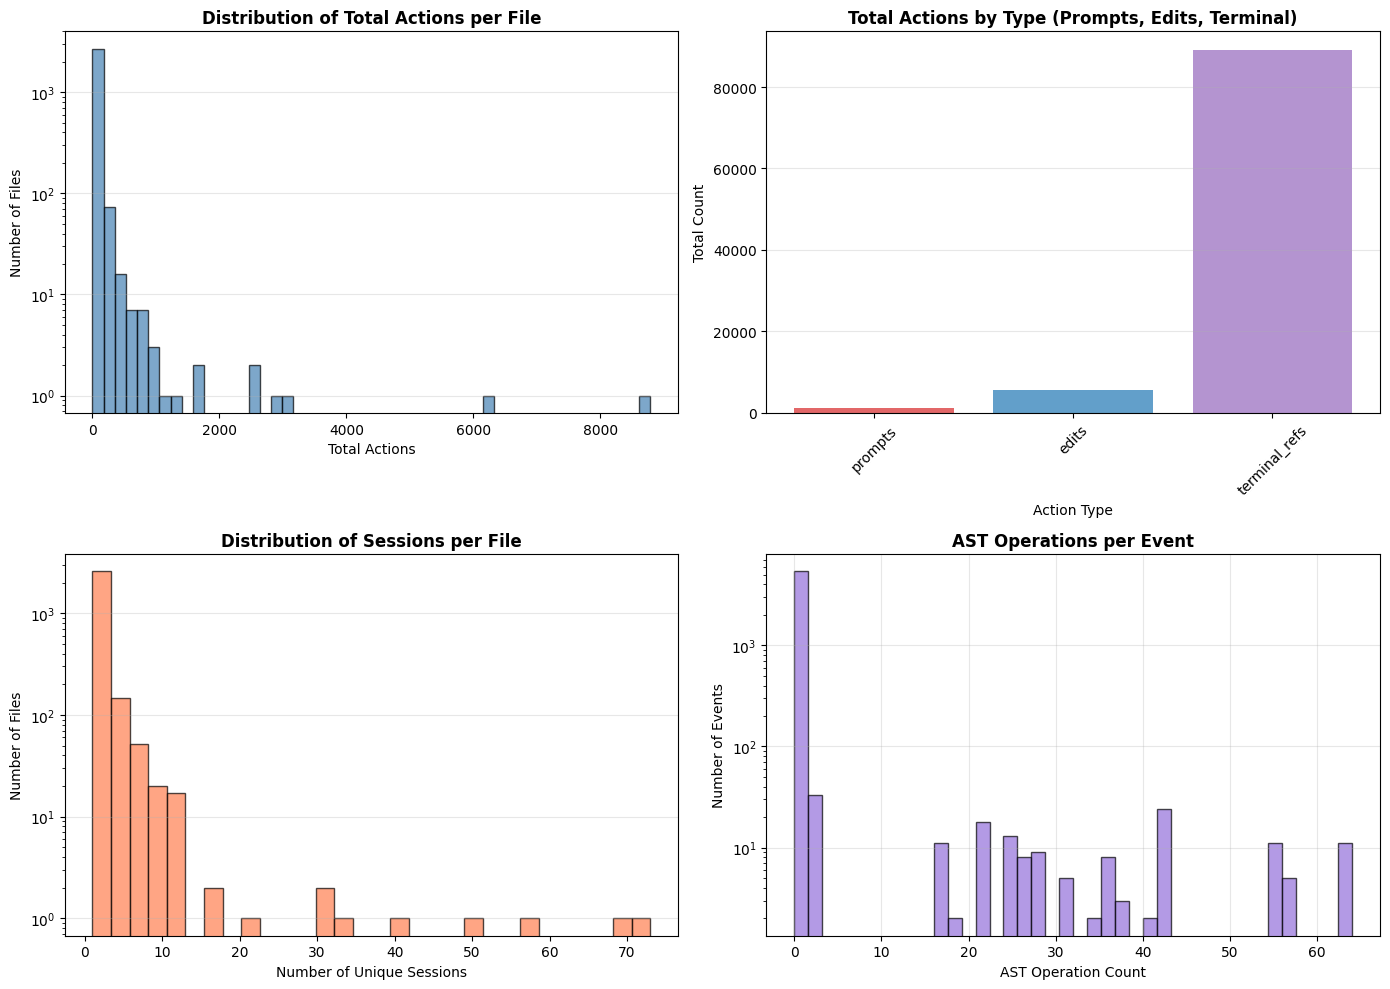


File Statistics Summary:
  Total files: 2814
  Files with edits: 2098
  Files with navigations: 0
  Files with AI context: 168
  Files referenced in terminal: 570
  Files with AST operations: 114


In [23]:
# File-level action statistics (if files rung is included)
if "files" in SELECTED_RUNGS:
    file_stats = get_file_action_stats(traces)
    
    # Create DataFrame for file statistics (no filtering - include all files)
    entries = []
    for path, stats in sorted(file_stats.items(), key=lambda x: sum([v for k, v in x[1].items() if k != "unique_sessions" and k != "operation_count"]), reverse=True):
        sum_activity = sum([v for k, v in stats.items() if k != "unique_sessions" and k != "operation_count"])
        # total_actions should be the sum of all tracked actions, not just AST operations
        total_actions = sum_activity + stats.get("operation_count", 0)
        entries.append({
            "file_path": path,
            "edits": stats["total_edits"],
            "navigations": stats["total_navigations"],
            "ai_context": stats["total_ai_context"],
            "prompts": stats["total_prompts"],
            "terminal_refs": stats["total_terminal_refs"],
            "unique_sessions": stats["unique_sessions"],
            "sum_actions": sum_activity,
            "operation_count": stats.get("operation_count", 0),
            "total_actions": total_actions,
        })
    file_df = pd.DataFrame(entries)
    
    if len(file_df) > 0:
        print(f"\nTop 20 files by total actions:")
        print(file_df.head(20).to_string(index=False))
    else:
        print("\nNo file statistics available.")
    
    if len(file_df) > 0:
        # Plot file action distribution
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Distribution of total actions per file
        ax1 = axes[0, 0]
        if (file_df["total_actions"] > 0).any():
            ax1.hist(file_df["total_actions"], bins=50, color="steelblue", alpha=0.7, edgecolor="black")
            ax1.set_yscale("log")
        ax1.set_title("Distribution of Total Actions per File", fontsize=12, fontweight="bold")
        ax1.set_xlabel("Total Actions", fontsize=10)
        ax1.set_ylabel("Number of Files", fontsize=10)
        ax1.grid(True, alpha=0.3, axis="y")
        
        # Action type breakdown - show prompts, edits, and terminal commands
        ax2 = axes[0, 1]
        # Focus on the three main action types: prompts, edits, terminal_refs
        action_totals = {
            "prompts": file_df["prompts"].sum(),
            "edits": file_df["edits"].sum(),
            "terminal_refs": file_df["terminal_refs"].sum(),
        }
        # Only show actions that have non-zero counts
        tracked_actions = [col for col, total in action_totals.items() if total > 0]
        tracked_totals = [action_totals[col] for col in tracked_actions]
        if tracked_actions:
            colors = {"prompts": "#d62728", "edits": "#1f77b4", "terminal_refs": "#9467bd"}
            ax2.bar(tracked_actions, tracked_totals, color=[colors[col] for col in tracked_actions], alpha=0.7)
        ax2.set_title("Total Actions by Type (Prompts, Edits, Terminal)", fontsize=12, fontweight="bold")
        ax2.set_ylabel("Total Count", fontsize=10)
        ax2.set_xlabel("Action Type", fontsize=10)
        ax2.tick_params(axis="x", rotation=45)
        ax2.grid(True, alpha=0.3, axis="y")
        
        # Distribution of sessions per file
        ax3 = axes[1, 0]
        if (file_df["unique_sessions"] > 0).any():
            ax3.hist(file_df["unique_sessions"], bins=30, color="coral", alpha=0.7, edgecolor="black")
            ax3.set_yscale("log")
        ax3.set_title("Distribution of Sessions per File", fontsize=12, fontweight="bold")
        ax3.set_xlabel("Number of Unique Sessions", fontsize=10)
        ax3.set_ylabel("Number of Files", fontsize=10)
        ax3.grid(True, alpha=0.3, axis="y")
        
        # Distribution of AST operations per event
        ax4 = axes[1, 1]
        event_ops = []
        for trace in traces:
            for event in trace.get("events", []):
                details = event.get("details") or {}
                after = details.get("after_content") or ""
                before = details.get("before_content") or ""
                snippet = after if len(after) > len(before) else before
                snippet = snippet or details.get("code") or details.get("content") or ""
                if snippet:
                    event_ops.append(count_ops(snippet))
        if event_ops:
            ax4.hist(event_ops, bins=40, color="mediumpurple", alpha=0.7, edgecolor="black")
            ax4.set_yscale("log")
        ax4.set_title("AST Operations per Event", fontsize=12, fontweight="bold")
        ax4.set_xlabel("AST Operation Count", fontsize=10)
        ax4.set_ylabel("Number of Events", fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        fig.savefig(RESULTS_DIR / "context_file_actions.png")
        plt.show()
        
        print(f"\nFile Statistics Summary:")
        print(f"  Total files: {len(file_df)}")
        print(f"  Files with edits: {(file_df['edits'] > 0).sum()}")
        print(f"  Files with navigations: {(file_df['navigations'] > 0).sum()}")
        print(f"  Files with AI context: {(file_df['ai_context'] > 0).sum()}")
        print(f"  Files referenced in terminal: {(file_df['terminal_refs'] > 0).sum()}")
        print(f"  Files with AST operations: {(file_df['operation_count'] > 0).sum()}")
    else:
        print("\nNo file data available for plotting.")


## Context Coverage Notes
- Most files only show `edits` counts because the companion export currently includes very few navigation/AI context/prompt/terminal events with file paths, so the other counters stay zero.
- All files are included in the statistics (no filtering) to provide a complete view of the data.
- The action breakdown plots show only tracked signals (edits), and the complexity scatter uses AST operation counts to highlight how busy or complex files are in the current data.
- AST operations are accumulated across all events for each file (sum), providing a measure of total code complexity encountered.
- When richer event streams (tabs/navigations/prompts) become available, this section can be extended with mission-based grouping to measure how each rung surfaces the right context.

In [24]:
import altair as alt
import pandas as pd

# Enable high-resolution export
alt.renderers.enable('default')
alt.data_transformers.enable('default')

# Prepare data for recall metrics
recall_data = pd.melt(
    df,
    id_vars=['rung'],
    value_vars=['recall@1', 'recall@5', 'recall@10'],
    var_name='metric',
    value_name='recall'
)
recall_data['metric'] = recall_data['metric'].str.replace('recall@', 'Recall@')

# Plot 1: Recall metrics (line chart)
chart_recall = alt.Chart(recall_data).mark_line(point=True, strokeWidth=3).encode(
    x=alt.X('rung:N', title='Representation Rung', sort=None),
    y=alt.Y('recall:Q', title='Recall', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('metric:N',
                   scale=alt.Scale(domain=['Recall@1', 'Recall@5', 'Recall@10'],
                                  range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                   legend=alt.Legend(title='Metric', orient='right')),
    tooltip=['rung', 'metric', alt.Tooltip('recall:Q', format='.3f')]
).properties(
    width=300,
    height=250,
    title='Context Retrieval Recall per Rung'
).configure_point(
    size=100
)

# Plot 2: MRR
chart_mrr = alt.Chart(df).mark_bar(color='#1f77b4', opacity=0.7, cornerRadius=4).encode(
    x=alt.X('rung:N', title='Representation Rung', sort=None),
    y=alt.Y('mrr:Q', title='MRR', scale=alt.Scale(domain=[0, 1])),
    tooltip=['rung', alt.Tooltip('mrr:Q', format='.3f')]
).properties(
    width=300,
    height=250,
    title='Mean Reciprocal Rank (MRR) per Rung'
)

# Plot 3: Average representation size
chart_size = alt.Chart(df).mark_bar(color='#ff7f0e', opacity=0.7, cornerRadius=4).encode(
    x=alt.X('rung:N', title='Representation Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('avg_size:Q', title='Bytes'),
    tooltip=['rung', alt.Tooltip('avg_size:Q', format=',.0f')]
).properties(
    width=300,
    height=250,
    title='Average Representation Size (bytes)'
)

# Plot 4: Average terms
chart_terms = alt.Chart(df).mark_bar(color='#2ca02c', opacity=0.7, cornerRadius=4).encode(
    x=alt.X('rung:N', title='Representation Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('avg_terms:Q', title='Terms', scale=alt.Scale(type='log')),
    tooltip=['rung', alt.Tooltip('avg_terms:Q', format=',.0f')]
).properties(
    width=300,
    height=250,
    title='Average Number of Terms'
)

# Combine charts
top_row = alt.hconcat(chart_recall, chart_mrr, spacing=20)
bottom_row = alt.hconcat(chart_size, chart_terms, spacing=20)
combined = alt.vconcat(top_row, bottom_row, spacing=30).configure(
    background='white',
    padding={'left': 10, 'top': 10, 'right': 10, 'bottom': 10}
).configure_title(
    fontSize=16,
    fontWeight='bold',
    anchor='start'
).configure_axis(
    labelFontSize=11,
    titleFontSize=12,
    titleFontWeight='bold'
).configure_legend(
    labelFontSize=10,
    titleFontSize=11,
    titleFontWeight='bold'
)

# Save high-resolution PNG
combined.save(RESULTS_DIR / "context_rung_metrics.png", scale_factor=2)
print("✓ Saved context retrieval plot to research/results/context_rung_metrics.png")

# Save interactive HTML
combined.save(RESULTS_DIR / "context_rung_metrics.html")
print("✓ Saved interactive HTML to research/results/context_rung_metrics.html")

combined.display()

# Print detailed results table
print("\n" + "="*80)
print("Detailed Results Summary")
print("="*80)
print(df.to_string(index=False))
print("\n" + "="*80)


TypeError: Objects with 'config' attribute cannot be used within HConcatChart. Consider defining the config attribute in the HConcatChart object instead.